In [1]:
#####Fast online bilinear factor model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
import seaborn as sns

#np.random.seed(98537)

In [2]:
####データの発生####
##データの設定
k = 10
hh = 10000
item = 3000
pt = np.random.poisson(np.random.gamma(10, 1/0.15), hh)
hhpt = np.sum(pt)
no = np.arange(hh)

In [3]:
##IDとインデックスの設定
#IDの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = index[d_id==i]
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [4]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[d_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
    
#インデックスを作成
item_list = [j for j in range(item)]    
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)
for j in range(item):
    item_list[j] = np.array(np.where(item_id==j)[0], dtype="int")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [5]:
##モデルの説明変数を生成
#ユーザーの説明変数を生成
k11 = 5; k12 = 6; k13 = 6
u11 = np.array(np.random.random(hh*k11)).reshape((hh, k11))
u12 = np.zeros((hh, k12))
for j in range(k12):
    prob = np.random.uniform(0.25, 0.55, 1)
    u12[:, j] = np.random.binomial(1, prob, hh)
u13 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k13), 1).reshape(k13), hh)
u13 = np.delete(u13, np.argmin(np.sum(u13, axis=0)), axis=1)   #冗長な変数の削除
u1 = np.concatenate((u11, u12, u13), axis=1)

#ユーザーの時変の説明変数を生成
k21 = 4; k22 = 5; k23 = 4
u21 = np.array(np.random.random(hhpt*k21)).reshape((hhpt, k21))
u22 = np.zeros((hhpt, k22))
for j in range(k22):
    prob = np.random.uniform(0.25, 0.5, 1)
    u22[:, j] = np.random.binomial(1, prob, hhpt)
u23 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k13), 1).reshape(k13), hhpt)
u23 = np.delete(u23, np.argmin(np.sum(u23, axis=0)), axis=1)   #冗長な変数の削除
u2 = np.concatenate((u21, u22, u23), axis=1)
u = np.concatenate((u1[d_id, ], u2), axis=1)
u_col = u.shape[1]

#アイテムの説明変数を生成
k21 =5; k22 = 5; k23 = 5
v11 = np.array(np.random.random(item*k21)).reshape((item, k21))
v12 = np.zeros((item, k22))
for j in range(k22):
    prob = np.random.uniform(0.25, 0.55, 1)
    v12[:, j] = np.random.binomial(1, prob, item)
v13 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k23), 1).reshape(k23), item)
v13 = np.delete(v13, np.argmin(np.sum(v13, axis=0)), axis=1)   #冗長な変数の削除
v1 = np.concatenate((v11, v12, v13), axis=1)
v = v1[item_id, ]
v_col = v.shape[1]

#素性ベクトルを生成
k1 = 4; k2 = 5; k3 = 4
x1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3, u, v), axis=1)   #すべての説明変数を結合
x_col = x.shape[1]

In [6]:
####妥当な応答変数が生成されるまで繰り返す####
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータを生成
    #アイテムの特徴ベクトルの事前分布
    alpha = np.repeat(0, k)
    tau = np.diag(np.repeat(0.2, k))
    alphat = alpha.copy(); taut = tau.copy()

    #モデルパラメータを生成
    Sigma = np.array([0.25])
    beta = np.append(5.5, np.random.normal(0, 0.3, x_col-1))
    theta1 = np.random.normal(0, 0.25, u_col*v_col).reshape(u_col, v_col)
    theta2 = np.random.normal(0, 0.3, u_col*k).reshape(u_col, k)
    gamma = np.random.multivariate_normal(alpha, tau, item)
    Sigmat = Sigma.copy(); betat = beta.copy(); thetat1 = theta1.copy(); thetat2 = theta2.copy(); gammat = gamma.copy()
    
    ##応答変数を生成
    #期待値を定義
    beta_mu = np.dot(x, beta)
    xAx = np.dot(np.dot(u, theta1) * v, np.repeat(1, v_col))
    xBx = np.dot(np.dot(u, theta2) * gamma[item_id, ], np.repeat(1, k))
    mu = beta_mu + xAx + xBx

    #正規分布からスコアを生成
    y_full = np.random.normal(mu, Sigma, hhpt)

    #応答変数のbreak条件
    if np.mean(y_full) > 4.5 and np.mean(y_full) < 6.5 and np.min(y_full) > -4.5 and np.max(y_full) < 15.5:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [7]:
#生成したスコアを評価データに変換
y = y_full.copy()
y[y < 1] = 1; y[y > 10] = 10
y_vec = np.round(y)

[5.601 5.598 5.598]
[1.754 1.73  1.755]


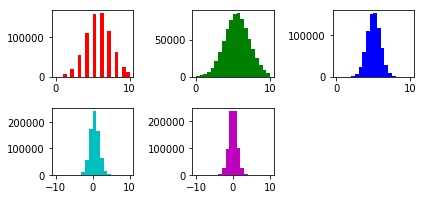

In [8]:
#生成したデータの確認
y_log = np.log(y)
print(np.round(np.array([np.mean(y_full), np.mean(y), np.mean(y_vec)]), 3))
print(np.round(np.array([np.std(y_full), np.std(y), np.std(y_vec)]), 3))

#潜在変数ごとのヒストグラム
dt = [y_vec, mu, beta_mu, xAx, xBx]
fig_range = np.append(np.array([0, 0, 0, -10, -10]), np.repeat(10, len(dt))).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure()
for j in range(len(dt)):
    ax = fig.add_subplot(3, 3, j+1)
    ax.hist(dt[j],  bins=20, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
fig.tight_layout()
plt.show()

In [9]:
####テストデータを作成####
##テストデータのIDを作成
#欠損インデックスを設定
z = np.random.binomial(1, 0.05, hh*item)
index_z = np.array(np.where(z==1)[0], dtype="int")
del z

#IDを作成
d_id0 = np.repeat(range(hh), item)[index_z]
item_id0 = np.tile(range(item), hh)[index_z]
N = d_id0.shape[0]

##テストデータの説明変数を生成
#ユーザーの説明変数を生成
k21 = 4; k22 = 5; k23 = 4
u21 = np.array(np.random.random(N*k21)).reshape((N, k21))
u22 = np.zeros((N, k22))
for j in range(k22):
    prob = np.random.uniform(0.25, 0.5, 1)
    u22[:, j] = np.random.binomial(1, prob, N)
u23 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k13), 1).reshape(k13), N)
u23 = np.delete(u23, np.argmin(np.sum(u23, axis=0)), axis=1)   #冗長な変数の削除
u2 = np.concatenate((u21, u22, u23), axis=1)
u0 = np.concatenate((u1[d_id0, ], u2), axis=1)

#アイテムの説明変数を生成
v0 = v1[item_id0, ]

#素性ベクトルを生成
k1 = 4; k2 = 5; k3 = 4
x1 = np.array(np.random.random(N*k1)).reshape((N, k1))
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x0 = np.concatenate((np.repeat(1, N)[:, np.newaxis], x1, x2, x3, u0, v0), axis=1)   #すべての説明変数を結合

##応答変数を生成
#期待値を定義
beta_mu = np.dot(x0, beta)
xAx = np.dot(np.dot(u0, theta1) * v0, np.repeat(1, v_col))
xBx = np.dot(np.dot(u0, theta2) * gamma[item_id0, ], np.repeat(1, k))
mu = beta_mu + xAx + xBx

#正規分布からスコアを生成
y_full0 = np.random.normal(mu, Sigma, N)

#生成したスコアを評価データに変換
y0 = y_full0.copy()
y0[y0 < 1] = 1; y0[y0 > 10] = 10
y_vec0 = np.round(y0)

In [10]:
####EMアルゴリズムでFOBFMを推定####
##データの設定
#定数の設定
xx = np.dot(x.T, x)
inv_xx = np.linalg.inv(xx)

#ユーザー-アイテム間の双線形モデルの説明変数を設定
allocation = np.arange(u_col*v_col).reshape(v_col, u_col, order="F")
uv = np.zeros((hhpt, u_col*v_col))
for j in range(u_col):
    uv[:, allocation[:, j]] = u[:, j][:, np.newaxis] * v
uuv = np.dot(uv.T, uv)
inv_uuv = np.linalg.inv(uuv)

#縮小ランク回帰の変数の割当
allocation = np.arange(u_col*k).reshape(k, u_col, order="F")

In [11]:
##パラメータの真値
#アイテム特徴ベクトルの事前分布の真値
alpha = alphat.copy()
tau = taut.copy()
inv_tau = np.linalg.inv(tau)

#モデルパラメータの真値
Sigma = Sigmat.copy()
beta = betat.copy()
theta1 = thetat1.copy()
theta2 = thetat2.copy()
gamma = gammat.copy()

#期待値を定義
beta_mu = np.dot(x, beta)
xAx = np.dot(np.dot(u, theta1) * v, np.repeat(1, v_col))
xBx = np.dot(np.dot(u, theta2) * gamma[item_id, ], np.repeat(1, k))
mu = beta_mu + xAx + xBx

In [12]:
##パラメータの初期値
#アイテム特徴ベクトルの事前分布の初期値
alpha = np.repeat(0, k)
tau = np.diag(np.repeat(1.0, k))
inv_tau = np.linalg.inv(tau)

#モデルパラメータの初期値
Sigma = np.array([0.5])
beta = np.random.normal(0, 0.2, x_col)
theta1 = np.random.multivariate_normal(np.repeat(0, v_col), np.diag(np.repeat(0.01, v_col)), u_col)
theta2 = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.01, k)), u_col)
gamma = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.01, k)), item)

#期待値を定義
beta_mu = np.dot(x, beta)
xAx = np.dot(np.dot(u, theta1) * v, np.repeat(1, v_col))
xBx = np.dot(np.dot(u, theta2) * gamma[item_id, ], np.repeat(1, k))
mu = beta_mu + xAx + xBx

In [13]:
##アルゴリズムの設定
LL1 = -1000000000   #対数尤度の初期値
tol = 5.0
iter = 1
dl = 100
L = 500   #モンテカルロサンプリング数

In [14]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y_vec, np.mean(y_vec), np.std(y_vec)))
print(LLst)

#真値での対数尤度
beta_mut = np.dot(x, betat)
xAxt = np.dot(np.dot(u, thetat1) * v, np.repeat(1, v_col))
xBxt = np.dot(np.dot(u, thetat2) * gammat[item_id, ], np.repeat(1, k))
mut = beta_mut + xAxt + xBxt
LLbest = np.sum(scipy.stats.norm.logpdf(y_vec, mut, Sigmat))
print(LLbest)

-1443106.932619139
-552003.4395374709


In [15]:
####EMアルゴリズムでパラメータを更新####
while np.abs(dl) > tol:   #dlがtol以上なら繰り返す
    
    ##Eステップでアイテム特徴ベクトルを更新
    #モデル誤差を設定
    Z = np.dot(u, theta2)
    er = y_vec - beta_mu - xAx

    #アイテムごとにパラメータを更新
    for j in range(item):
        index = item_list[j]; z = Z[index, ]
        zy = np.dot(z.T, er[index])
        zzv = np.dot(z.T, z) + inv_tau
        inv_zzv = np.linalg.inv(zzv)
        gamma[j, ] = np.dot(inv_zzv, zy + np.dot(inv_tau, alpha))

    #縮小ランク回帰の期待値を更新
    gamma_vec = gamma[item_id, ]
    xBx = np.dot(Z * gamma[item_id, ], np.repeat(1, k))

    
    ##Mステップの回帰パラメータを更新
    #素性ベクトルを更新
    er = y_vec - xAx - xBx
    beta = np.dot(np.dot(inv_xx, x.T), er)
    beta_mu = np.dot(x, beta)

    #ユーザーとアイテムの交互作用の回帰行列を更新
    er = y_vec - beta_mu - xBx
    theta1 = np.dot(np.dot(inv_uuv, uv.T), er).reshape(u_col, v_col)
    xAx = np.dot(np.dot(u, theta1) * v, np.repeat(1, v_col))

    #縮小ランク回帰の回帰行列を更新
    er = y_vec - beta_mu - xAx
    w = np.zeros((hhpt, u_col*k))
    for j in range(u_col):
        w[:, allocation[:, j]] = u[:, j][:, np.newaxis] * gamma_vec
    theta2 = np.dot(np.dot(np.linalg.inv(np.dot(w.T, w)), w.T), er).reshape(u_col, k)
    xBx = np.dot(np.dot(u, theta2) * gamma[item_id, ], np.repeat(1, k))

    
    ##Mステップの分散パラメータを更新
    #モデル分散を更新
    er = y - beta_mu - xAx - xBx
    theta_mu2 = np.dot(u, theta2)
    V = np.dot(np.dot(theta_mu2, np.power(Sigma, 2) * inv_zzv) * theta_mu2, np.repeat(1, k))
    Sigma = np.sqrt(np.sum(np.power(er, 2) + V) / hhpt)

    #事前分布の分散を更新
    S = np.sum(np.power(gamma, 2)) + np.sum(np.diag(np.power(Sigma, 2) * inv_zzv))
    tau = np.diag(np.repeat(S / (item*k), k))
    inv_tau = np.linalg.inv(tau)


    ##対数尤度の更新とアルゴリズムの収束判定
    #対数尤度の更新
    mu = beta_mu + xAx + xBx
    LL = np.sum(scipy.stats.norm.logpdf(y_vec, mu, Sigma))

    #アルゴリズムの収束判定
    iter = iter + 1
    dl = LL- LL1
    LL1 = LL
    print(np.round(np.array([LL, LLst, LLbest]), 1))

[ -883513.6 -1443106.9  -552003.4]
[ -518996.6 -1443106.9  -552003.4]
[ -473622.6 -1443106.9  -552003.4]
[ -464953.8 -1443106.9  -552003.4]
[ -462167.7 -1443106.9  -552003.4]
[ -460751.1 -1443106.9  -552003.4]
[ -459663.4 -1443106.9  -552003.4]
[ -458677.7 -1443106.9  -552003.4]
[ -457752.7 -1443106.9  -552003.4]
[ -456886.5 -1443106.9  -552003.4]
[ -456083.1 -1443106.9  -552003.4]
[ -455344.9 -1443106.9  -552003.4]
[ -454671.1 -1443106.9  -552003.4]
[ -454058.7 -1443106.9  -552003.4]
[ -453502.5 -1443106.9  -552003.4]
[ -452996.8 -1443106.9  -552003.4]
[ -452535.5 -1443106.9  -552003.4]
[ -452113.1 -1443106.9  -552003.4]
[ -451724.4 -1443106.9  -552003.4]
[ -451365.  -1443106.9  -552003.4]
[ -451031.3 -1443106.9  -552003.4]
[ -450720.2 -1443106.9  -552003.4]
[ -450429.1 -1443106.9  -552003.4]
[ -450156.  -1443106.9  -552003.4]
[ -449899.  -1443106.9  -552003.4]
[ -449656.8 -1443106.9  -552003.4]
[ -449428.1 -1443106.9  -552003.4]
[ -449211.9 -1443106.9  -552003.4]
[ -449007.2 -1443106

In [16]:
##テストデータに対する対数尤度
#真値での対数尤度
beta_mu = np.dot(x0, betat)
xAx = np.dot(np.dot(u0, thetat1) * v0, np.repeat(1, v_col))
xBx = np.dot(np.dot(u0, thetat2) * gammat[item_id0, ], np.repeat(1, k))
mu = beta_mu + xAx + xBx
LLbest = np.sum(scipy.stats.norm.logpdf(y_vec0, mu, Sigmat))
print(LLbest)

#推定値での対数尤度
beta_mu = np.dot(x0, beta)
xAx = np.dot(np.dot(u0, theta1) * v0, np.repeat(1, v_col))
xBx = np.dot(np.dot(u0, theta2) * gamma[item_id0, ], np.repeat(1, k))
mu = beta_mu + xAx + xBx
LL = np.sum(scipy.stats.norm.logpdf(y_vec0, mu, Sigma))
print(LL)

-1131168.7939044095
-1047718.3032794986
